<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/linear_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear neuron

##1. LSQ Algorithm and Gradient descent algorithm
- and the SSE (The Sum squared error), SAE (The Sum absolute error), MSE (The Mean squared error), MAE (The Mean absolute error) functions



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class LinearNeuron:
    def __init__(self, input_dim, init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"LinearNeuron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        return x

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def LSQ(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug, _, _, _ = np.linalg.lstsq(X_aug, true_outputs, rcond=None)  # using library function

        self.weights = weights_aug[:-1].reshape(-1, 1)  # ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_pseudoinverse(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ true_outputs       # Moore-Penrose pseudoinverse

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_tichonov(self, training_inputs, true_outputs, lambda_reg=1e-5):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        n = X_aug.shape[1]
        weights_aug = np.linalg.solve((X_aug.T @ X_aug) + np.eye(n) * lambda_reg, X_aug.T @ true_outputs)

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())

    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            for inputs, true_output in zip(training_inputs, true_outputs):
                prediction = self.forward(inputs.T)  # Ensure row vector for forward pass
                error = true_output - prediction
                self.weights += learning_rate * error * inputs.reshape(-1, 1)  # Update weights correctly
                self.bias += float((learning_rate * error).item())  # Update bias

            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse

            mse = MSE_error(true_outputs, self.forward(training_inputs))
            training_errors.append(mse)
            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error) or (max_validation_steps and validation_steps > max_validation_steps):
                break
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.")
        self.epochs = epoch+1
        return training_errors, validation_errors

    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate
        for epoch in range(epochs):
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            errors = true_outputs - prediction  # (m, 1)
            weight_gradient = (training_inputs.T @ errors)   # (n, 1)
            bias_gradient = np.sum(errors)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar

            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)

            if print_progress:
                print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            if mse <= min_error:
                break
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.")
        self.epochs = epoch + 1

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()

def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(5, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != predicted_outputs)

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)

def run_example_LSQ(experiment_results, inputs, true_outputs, init_method, variant, data_description):
    times = []
    errors = []
    epoch_counts = []

    start_time = time.time()
    perceptron = LinearNeuron(inputs.shape[1], init_method)
    if variant == 'pseudoinverse':
        perceptron.LSQ_pseudoinverse(inputs, true_outputs)
    elif variant == 'tichonov':
        perceptron.LSQ_tichonov(inputs, true_outputs)
    elif variant == 'library':
        perceptron.LSQ(inputs, true_outputs)
    elif variant == 'gradient':
        perceptron.gradient_descent_iterative(inputs, true_outputs)
    elif variant == 'batch':
        perceptron.gradient_descent_batch(inputs, true_outputs)
    end_time = time.time()
    elapsed_time = end_time - start_time

    real_outputs = perceptron.forward(inputs)
    error_MSE = MSE_error(true_outputs, real_outputs)
    error_SSE = SSE_error(true_outputs, real_outputs)

    results = {
        'MSE': error_MSE,
        'SSE': error_SSE,
        'Time': elapsed_time,
        'Variant': variant,
        'Weights': perceptron.weights,
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results

### Example 1
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:
- observe carefully the predicted values

LinearNeuron(weights=[[-0.5 -0.5]], bias=0.5)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 1.0
MSE error: 0.25
SAE error: 2.0
MAE error: 0.5


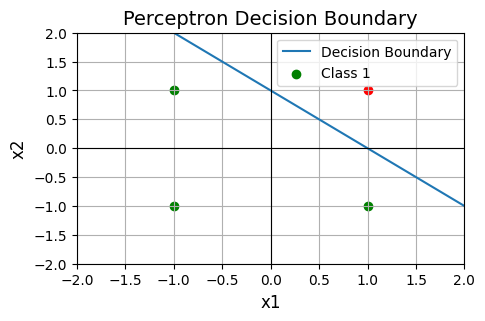

,Input,Predicted,True
0,"[-1, -1]",[1.5],1
1,"[-1, 1]",[0.5],1
2,"[1, -1]",[0.5],1
3,"[1, 1]",[-0.5],-1


In [2]:
# Example 1 from the presentation:
# Data:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
#variant = "tichonov"
variant = "pseudoinverse"
#variant = "library"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- comparison of LSQ variants:

In [3]:
# Example 1
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description = "Ex. 1"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,0.25000,1.000000,0.000234,library,"[[-0.5], [-0.49999999999999994]]",0.500000,Ex. 1
1,0.25000,1.000000,0.000202,pseudoinverse,"[[-0.5], [-0.5]]",0.500000,Ex. 1
2,0.25000,1.000000,0.000203,tichonov,"[[-0.49999875000312505], [-0.49999875000312505]]",0.499999,Ex. 1
3,0.25065,1.002599,0.047324,gradient,"[[-0.5134694786488401], [-0.4787023048101067]]",0.496178,Ex. 1
4,0.25000,1.000000,0.015562,batch,"[[-0.49999999999999994], [-0.5]]",0.500000,Ex. 1


### Example 2
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:

LinearNeuron(weights=[[ 0.       -0.999995]], bias=0.0)
LSQ: tichonov
Perceptron error: 2
SSE error: 4.999950000408418e-11
MSE error: 2.499975000204209e-11
SAE error: 9.99995000028342e-06
MAE error: 4.99997500014171e-06


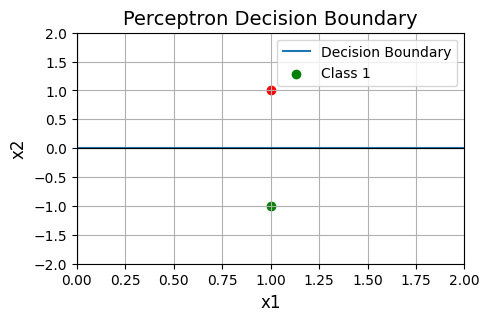

,Input,Predicted,True
0,"[1, -1]",[0.9999950000249999],1
1,"[1, 1]",[-0.9999950000249999],-1


In [4]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
#variant = "library"
#variant = "pseudoinverse"
variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


-comparison of LSQ variants:

In [5]:
# Example 2 from the presentation:
# Data and parameters:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description = "Ex. 2"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)




Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,3.204747e-31,6.409495e-31,0.004443,library,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,Ex. 2
1,0.000000e+00,0.000000e+00,0.000393,pseudoinverse,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2
2,2.499975e-11,4.999950e-11,0.000173,tichonov,"[[0.0], [-0.9999950000249999]]",0.000000e+00,Ex. 2
3,1.109336e-31,2.218671e-31,0.012429,gradient,"[[9.76203933585035e-18], [-0.9999999999999997]]",9.762039e-18,Ex. 2
4,0.000000e+00,0.000000e+00,0.000323,batch,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2


### Example: XOR

LinearNeuron(weights=[[0. 0.]], bias=0.0)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 4.0
MSE error: 1.0
SAE error: 4.0
MAE error: 1.0


<ipython-input-1-ada293fcb08b>:190: RuntimeWarning: invalid value encountered in divide
  y = -(weights[0] * x + perceptron.bias) / weights[1]


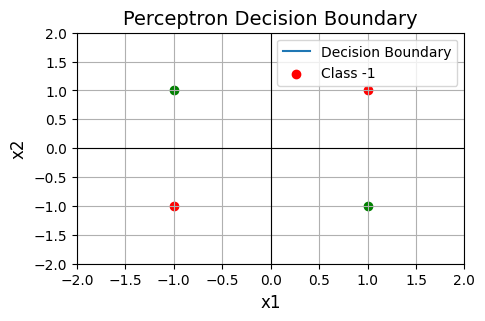

,Input,Predicted,True
0,"[-1, -1]",[0.0],-1
1,"[-1, 1]",[0.0],1
2,"[1, -1]",[0.0],1
3,"[1, 1]",[0.0],-1


In [6]:
# Example XOR:
# Data:
inputs = np.array([ [-1, -1],
                    [-1,  1],
                    [ 1, -1],
                    [ 1,  1]])
true_outputs = np.array([-1, 1, 1, -1])
#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

### Example 3: Linear regression


- create the data:

In [7]:
def generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100):
    # y = A x1 + C + noise

    inputs = np.random.uniform(-1, 1, size=(number_of_samples, 1))  # Random values between -1 and 1
    true_outputs = 1.5 * inputs[:, [0]] + 3 + np.random.randn(number_of_samples, 1) * std_noise  # Gaussian noise

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=inputs.shape)  # Gaussian noise
    true_outputs = A * inputs[:, [0]]  + B + noise
    return inputs, true_outputs

inputs, true_outputs = generate_regression_data_1D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data


LinearNeuron(weights=[[1.43095832]], bias=2.962129237918993)
LSQ: pseudoinverse
Perceptron error: 10000
MSE error: 1.4063075164802952
MAE error: 0.9651423955146613


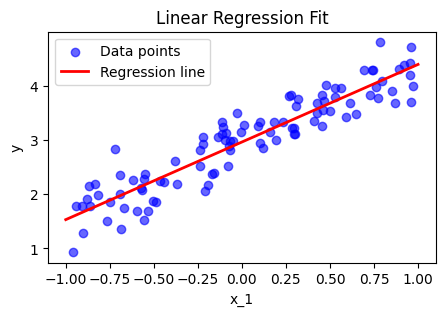

,Input,Predicted,True
0,[-0.20990812034704476],[2.661759465806039],[2.0562509703374445]
1,[-0.7185480998948157],[1.933916853087162],[2.8286169932759386]
2,[-0.10564318620955371],[2.8109582412248826],[3.246968542544124]
3,[0.10316019569078905],[3.1097471786615425],[3.33942752930067]
4,[0.19574232402282998],[3.2422283458638903],[3.0024786285267946]
...,...,...,...
95,[0.7928741410545266],[4.096699090047895],[4.094390865055515]
96,[0.5262227307135892],[3.715132034779693],[3.7908297486979903]
97,[0.26761620161423116],[3.3450768692907618],[3.817900949430608]
98,[0.45971548230348347],[3.619962934052312],[3.5608629433658057]


In [8]:
# Example: simple linear regression
# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

- comparison of LSQ variants:

In [9]:

# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
data_description = "Lin. regr. 1"
init_method = 'random'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,1.419357e+00,1.419357e+04,0.000232,library,[[1.545184857788829]],3.001369e+00,Lin. regr. 1
1,1.419357e+00,1.419357e+04,0.000219,pseudoinverse,[[1.5451848577888294]],3.001369e+00,Lin. regr. 1
2,1.419356e+00,1.419356e+04,0.004339,tichonov,[[1.5451843137956713]],3.001368e+00,Lin. regr. 1
3,1.378461e+00,1.378461e+04,0.248291,gradient,[[1.496479615755977]],2.971656e+00,Lin. regr. 1
4,8.751966e+236,8.751966e+240,0.005626,batch,[[-1.4684182432035928e+116]],-2.958310e+118,Lin. regr. 1


- observe how the level of noise in the data affects the training and error

In [10]:
# Data and parameters
data_description = "Lin. regr. 1"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 10]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,1.577292,1.577292e+04,0.000303,pseudoinverse,[[1.500049531226297]],3.000372,Lin. regr. 1
1,1.590032,1.590032e+04,0.000294,pseudoinverse,[[1.5004953122629763]],3.003717,Lin. regr. 1
2,2.779657,2.779657e+04,0.000191,pseudoinverse,[[1.5049531226297659]],3.037169,Lin. regr. 1
3,120.898450,1.208984e+06,0.000285,pseudoinverse,[[1.5495312262976673]],3.371689,Lin. regr. 1


### Example 4 - Linear regression with two input dimensions

- create and observe the data:

In [11]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, true_outputs

inputs, true_outputs = generate_regression_data_2D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data





LinearNeuron(weights=[[1.99205316 2.56079854]], bias=-3.780611991064234)
LSQ: pseudoinverse
Perceptron error: 10000
MSE error: 10.169711067524903
MAE error: 2.5344675577029108


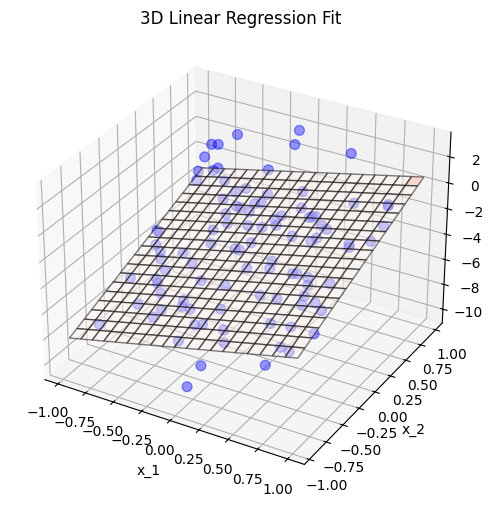

(100, 2)


,Input,Predicted,True
0,"[0.9953852318476866, -0.1948999128060389]",[-2.2968511078533167],[0.7757101785998475]
1,"[0.5048062400776454, 0.7221360399494432]",[-0.9257662089629508],[2.4195358871601806]
2,"[0.41396092248691807, -0.005070212040218847]",[-2.9689636193601623],[-0.9316521076738415]
3,"[0.5571438781015021, 0.20639480435395918]",[-2.142216255043649],[-7.296322838744547]
4,"[-0.7137440289030608, 0.4718092263920046]",[-3.994219660277839],[-1.4648428905739053]
...,...,...,...
95,"[-0.06353634311724132, 0.13888703552700066]",[-3.55151804624448],[-5.284202949776191]
96,"[0.24995197410210457, -0.7178363024445729]",[-5.120928526888324],[-5.166472906124892]
97,"[-0.2445481051196614, 0.6613090131304995]",[-2.574285660920501],[-2.901855280124415]
98,"[0.6731296265846658, -0.27388157560981896]",[-3.1410575310966626],[-3.579439206891413]


In [12]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)
print(np.shape(inputs))

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- observe how the level of noise in the data affects the training and error

In [13]:
# Data and parameters
data_description = "Lin. regr. 2"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 2]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C = -4, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,9.469434,94694.337416,0.000274,pseudoinverse,"[[2.0033162865773786], [2.995430899968277]]",-3.999275,Lin. regr. 2
1,9.398240,93982.402026,0.000184,pseudoinverse,"[[2.0331628657738046], [2.954308999682752]]",-3.992748,Lin. regr. 2
2,9.797116,97971.159983,0.000164,pseudoinverse,"[[2.3316286577380607], [2.543089996827503]]",-3.927485,Lin. regr. 2
3,12.609044,126090.444963,0.000166,pseudoinverse,"[[2.6632573154761228], [2.0861799936550036]]",-3.854970,Lin. regr. 2


##2. Iterative and batch gradient descent algorithm:


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time



def run_example_multiple_times(experiment_results, training_data, testing_data, validation_data, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=10, num_runs=10):
    inputs, true_outputs = training_data
    if testing_data is None:
        testing_data = training_data
    max_validation_steps = None if validation_data is None else max_validation_steps
    test_inputs, test_true_outputs = testing_data
    times = []
    mse_errors = []
    mae_errors = []
    mse_test_errors = []
    mae_test_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = LinearNeuron(inputs.shape[1], init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress)
        elif variant == 'batch':
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress, print_progress=print_progress)
        elif variant == 'pseudoinverse':
            neuron.LSQ_pseudoinverse(inputs, true_outputs)
        elif variant == 'tichonov':
            neuron.LSQ_tichonov(inputs, true_outputs)
        else:
            neuron.LSQ(inputs, true_outputs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        real_outputs = neuron.forward(test_inputs)
        mse_test = MSE_error(test_true_outputs, real_outputs)
        mae_test = MAE_error(test_true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        mse_test_errors.append(mse_test)
        mae_test_errors.append(mae_test)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_test_mse = np.mean(mse_test_errors)
    avg_test_mae = np.mean(mae_test_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Test MSE': avg_test_mse,
        'Test MAE': avg_test_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Test MSE' 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

### Example 1
- observe the training process, does the algorithm converge?
- experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process
- try to initialize weights with large values and observe, how it affects training

Gradient Descent iterative:
Epoch: 0, MSE: 0.8855 Weights: [[-0.03185424 -0.01474453]] Bias: 0.07476046023431046 Learning rate: 0.0300
Epoch: 1, MSE: 0.7434 Weights: [[-0.08827701 -0.07119924]] Bias: 0.1258689196348467 Learning rate: 0.0300
Epoch: 2, MSE: 0.6331 Weights: [[-0.13762368 -0.12097591]] Bias: 0.1712098768519657 Learning rate: 0.0300
Epoch: 3, MSE: 0.5483 Weights: [[-0.17991015 -0.16672197]] Bias: 0.20883587859311423 Learning rate: 0.0300
Epoch: 4, MSE: 0.4804 Weights: [[-0.22005422 -0.20702479]] Bias: 0.24266596094018028 Learning rate: 0.0300
Epoch: 5, MSE: 0.4305 Weights: [[-0.25356549 -0.24071294]] Bias: 0.2706958222896902 Learning rate: 0.0300
Epoch: 6, MSE: 0.3900 Weights: [[-0.2817788  -0.27178866]] Bias: 0.29919003239601594 Learning rate: 0.0300
Epoch: 7, MSE: 0.3585 Weights: [[-0.30906527 -0.29784745]] Bias: 0.3233343605244594 Learning rate: 0.0300
Epoch: 8, MSE: 0.3341 Weights: [[-0.33312427 -0.32210281]] Bias: 0.3432989924005199 Learning rate: 0.0300
Epoch: 9, MSE:

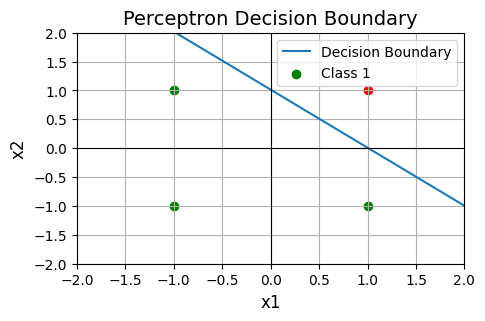

,Input,Predicted,True
0,"[-1, -1]",[1.2638197097212893],1
1,"[-1, 1]",[0.42670933127615823],1
2,"[1, -1]",[0.4223823203592611],1
3,"[1, 1]",[-0.41472805808587004],-1


In [22]:
# Example 1 from the presentation:
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])

print_progress = True
learning_rate = 0.03
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [23]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description_orig = "Ex. 1"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None,  epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.25,0.5,-1.0,0.000459,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
1,0.25,0.5,-1.0,0.000136,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
2,0.25,0.5,-1.0,0.000045,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
3,0.25,0.5,-1.0,0.000048,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
4,0.25,0.5,-1.0,0.000097,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
5,0.25,0.5,-1.0,0.000041,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
6,0.25,0.5,-1.0,0.000040,Ex. 1 non-adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,False
7,0.25,0.5,-1.0,0.000039,Ex. 1 adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,True
8,0.25,0.5,-1.0,0.000041,Ex. 1 adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,True
9,0.25,0.5,-1.0,0.000043,Ex. 1 adaptive 0.0001,False,random,"[[-0.5], [-0.49999999999999994]]",0.5,True


### Example 2
- observe the training process, does the algorithm converge?
- experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process

Gradient Descent iterative:
Epoch: 0, MSE: 0.6077 Weights: [[-0.04689374 -0.2249948 ]] Bias: -0.03711530183596336 Learning rate: 0.1000
Epoch: 1, MSE: 0.3772 Weights: [[-0.02318197 -0.3869058 ]] Bias: -0.013403532704999582 Learning rate: 0.1000
Epoch: 2, MSE: 0.2351 Weights: [[-0.01009978 -0.51528973]] Bias: -0.0003213458690019405 Learning rate: 0.1000
Epoch: 3, MSE: 0.1467 Weights: [[-0.00327266 -0.61697467]] Bias: 0.006505770695582461 Learning rate: 0.1000
Epoch: 4, MSE: 0.0916 Weights: [[-5.67001336e-05 -6.97442322e-01]] Bias: 0.00972173350200764 Learning rate: 0.1000
Epoch: 5, MSE: 0.0572 Weights: [[ 0.00113252 -0.76107608]] Bias: 0.010910953942420792 Learning rate: 0.1000
Epoch: 6, MSE: 0.0357 Weights: [[ 0.0012335  -0.81137054]] Bias: 0.011011932988254987 Learning rate: 0.1000
Epoch: 7, MSE: 0.0223 Weights: [[ 7.93161791e-04 -8.51105182e-01]] Bias: 0.010571595427078757 Learning rate: 0.1000
Epoch: 8, MSE: 0.0139 Weights: [[ 1.22806098e-04 -8.82486742e-01]] Bias: 0.009901239733361

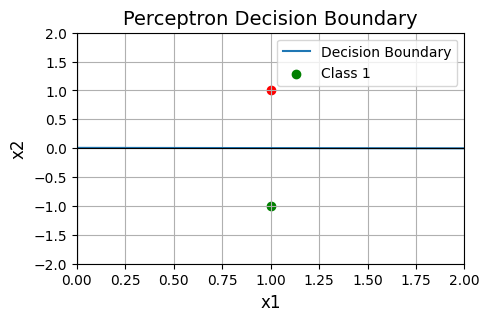

,Input,Predicted,True
0,"[1, -1]",[0.9737922349536338],1
1,"[1, 1]",[-0.9692900786964819],-1


In [24]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [25]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description_orig = "Ex. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None,  epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

print("\nExperiment Results:")
experiment_results_r #.round(5)


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,3.204747e-31,5.551115e-16,-1.0,0.000096,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
1,3.204747e-31,5.551115e-16,-1.0,0.000085,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
2,3.204747e-31,5.551115e-16,-1.0,0.000062,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
3,3.204747e-31,5.551115e-16,-1.0,0.000046,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
4,3.204747e-31,5.551115e-16,-1.0,0.000057,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
5,3.204747e-31,5.551115e-16,-1.0,0.000045,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
6,3.204747e-31,5.551115e-16,-1.0,0.000043,Ex. 2 non-adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,False
7,3.204747e-31,5.551115e-16,-1.0,0.000044,Ex. 2 adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,True
8,3.204747e-31,5.551115e-16,-1.0,0.000041,Ex. 2 adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,True
9,3.204747e-31,5.551115e-16,-1.0,0.000042,Ex. 2 adaptive 0.0001,False,random,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,True


### Example 3: linear regression
- observe the training process of the iterative training algorithm, does the algorithm converge? Is the neuron function close to the true function?
- compare the error on the training data and on the testing data
- experiment with the noise levels and with the training parameters (learning rate, maximum number of epochs, weight initialization, adaptive learning rate,...) and observe, how it affects the training process

In [26]:
# Example: linear regression
# Training and testing data:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


UnboundLocalError: cannot access local variable 'validation_steps' where it is not associated with a value

#### Example 3 and the batch variant of gradient descent
- observe the training progress, compare it to the iterative variant
- experiment with the learning rate and with the number of epochs

Gradient Descent batch:
Epoch: 0, MSE: 0.3631 Weights: [[0.44744592]] Bias: 3.060821891176198 Learning rate: 0.0100
Epoch: 1, MSE: 0.2710 Weights: [[0.63685243]] Bias: 3.052980526995521 Learning rate: 0.0071
Epoch: 2, MSE: 0.2205 Weights: [[0.76249168]] Bias: 3.0484856265378317 Learning rate: 0.0058
Epoch: 3, MSE: 0.1887 Weights: [[0.85462458]] Bias: 3.045335480299446 Learning rate: 0.0050
Epoch: 4, MSE: 0.1672 Weights: [[0.92609286]] Bias: 3.042939636574211 Learning rate: 0.0045
Epoch: 5, MSE: 0.1519 Weights: [[0.98358836]] Bias: 3.0410316840316103 Learning rate: 0.0041
Epoch: 6, MSE: 0.1406 Weights: [[1.03104948]] Bias: 3.0394658105213797 Learning rate: 0.0038
Epoch: 7, MSE: 0.1319 Weights: [[1.07099033]] Bias: 3.0381527095042604 Learning rate: 0.0035
Epoch: 8, MSE: 0.1253 Weights: [[1.10511224]] Bias: 3.037033467103199 Learning rate: 0.0033
Epoch: 9, MSE: 0.1200 Weights: [[1.13461834]] Bias: 3.0360671052133874 Learning rate: 0.0032
Epoch: 10, MSE: 0.1157 Weights: [[1.16038933]] Bias

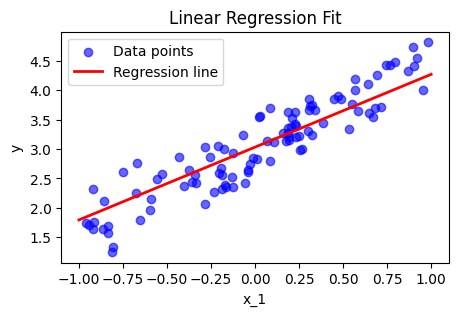

,Input,Predicted,True
0,[-0.855167455707317],[1.9745824303153705],[2.1128782011571827]
1,[0.06848441195289023],[3.1174481160879743],[3.128784366877876]
2,[0.7650669716392],[3.9793532695846157],[4.422588997306059]
3,[-0.8349829311191574],[1.9995574250543269],[1.699601611211699]
4,[0.6490280937936677],[3.835774442595219],[3.6175330053841215]
...,...,...,...
95,[-0.8094769840907474],[2.031116795703082],[1.2469758279189564]
96,[0.30424649106087576],[3.409164508002472],[3.8497328057090336]
97,[-0.37570388660710585],[2.567838915673637],[2.6447660657729526]
98,[-0.20190810772577783],[2.7828823091534223],[2.599086950492693]


In [27]:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters of the iterative / batch algoritm:
    1. learning rate
    2. number of epochs
    3. ...

In [28]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

data_description_orig = "regr. 1"
variant = "iterative" # "batch"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Test MSE,Test MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.424733,0.97102,1.122665,0.880666,-1.0,0.000087,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
1,1.424733,0.97102,1.122665,0.880666,-1.0,0.000046,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
2,1.424733,0.97102,1.122665,0.880666,-1.0,0.000045,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
3,1.424733,0.97102,1.122665,0.880666,-1.0,0.000048,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
4,1.424733,0.97102,1.122665,0.880666,-1.0,0.000046,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
5,1.424733,0.97102,1.122665,0.880666,-1.0,0.000045,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
6,1.424733,0.97102,1.122665,0.880666,-1.0,0.000049,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False
7,1.424733,0.97102,1.122665,0.880666,-1.0,0.000047,regr. 1 non-adaptive 0.0001,False,random,[[1.4569236111201018]],3.019007,False


- comprate the iterative and batch algorithms:
    1. learning rate
    2. error and training time

In [29]:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

data_description_orig = "regr. 1"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

variant = 'batch'
for learning_rate in [0.001, 0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

variant = 'iterative'
for learning_rate in [0.001, 0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Test MSE,Test MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.567341,1.018888,1.298982,0.985011,-1.0,0.000098,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
1,1.567341,1.018888,1.298982,0.985011,-1.0,0.000047,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
2,1.567341,1.018888,1.298982,0.985011,-1.0,0.000043,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
3,1.567341,1.018888,1.298982,0.985011,-1.0,0.000038,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
4,1.567341,1.018888,1.298982,0.985011,-1.0,0.000042,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
5,1.567341,1.018888,1.298982,0.985011,-1.0,0.000040,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
6,1.567341,1.018888,1.298982,0.985011,-1.0,0.000041,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False
7,1.567341,1.018888,1.298982,0.985011,-1.0,0.000039,regr. 1 non-adaptive 0.0001,False,random,[[1.5013854340445576]],3.022837,False


### Example 4 - Linear regression with two input dimensions


-   observe the training process of the iterative training algorithm, does the algorithm converge? Is the neuron function close to the true function?
-  compare the error on the training data and on the testing data
-  experiment with the noise levels and with the training parameters (learning rate, maximum number of epochs, weight initialization, adaptive learning rate,...) and observe, how it affects the training process


Gradient Descent iterative:
Epoch: 0, MSE: 10.1179 Weights: [[1.98730351 3.11474529]] Bias: -4.19631471411714 Learning rate: 0.1000
Epoch: 1, MSE: 9.7744 Weights: [[2.11582682 2.85392146]] Bias: -4.203795477421216 Learning rate: 0.0707
Epoch: 2, MSE: 9.6885 Weights: [[1.84190137 3.03806121]] Bias: -3.963812641117881 Learning rate: 0.0577
Epoch: 3, MSE: 9.9472 Weights: [[1.96218277 3.07517187]] Bias: -4.022154284902261 Learning rate: 0.0500
Epoch: 4, MSE: 10.0236 Weights: [[2.00289865 3.08229763]] Bias: -3.98289717179331 Learning rate: 0.0447
Epoch: 5, MSE: 10.0744 Weights: [[1.9560122  3.13731072]] Bias: -3.9600868112551018 Learning rate: 0.0408
Epoch: 6, MSE: 10.0018 Weights: [[1.96499033 3.09841984]] Bias: -4.009701213137237 Learning rate: 0.0378
Epoch: 7, MSE: 9.8977 Weights: [[1.96846504 3.04702798]] Bias: -3.9178453417653456 Learning rate: 0.0354
Epoch: 8, MSE: 9.9350 Weights: [[1.94651409 3.08111576]] Bias: -3.98401808149299 Learning rate: 0.0333
Epoch: 9, MSE: 9.8052 Weights: [[

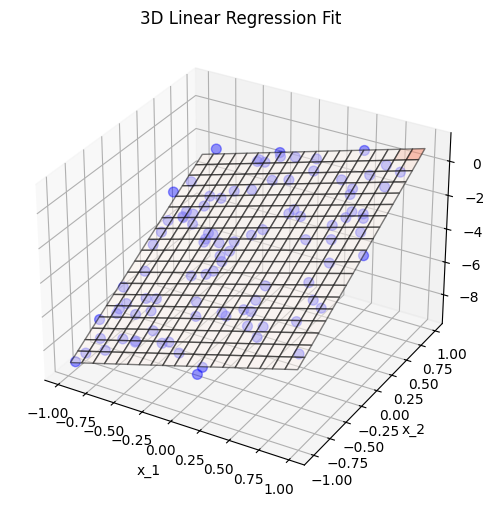

,Input,Predicted,True
0,"[-0.3855671659574582, -0.18681892528105548]",[-5.3142271117102355],[-5.358543532260953]
1,"[0.09291708345624872, -0.48281681773043195]",[-5.284916742426882],[-5.7537680764674555]
2,"[-0.16561316287084704, -0.8801133982773834]",[-6.99888438715202],[-6.41063759245861]
3,"[-0.6795487980469874, 0.23877993873300385]",[-4.589454994981826],[-3.482737418886334]
4,"[-0.6581271951583034, 0.559033402848127]",[-3.571797491675191],[-3.5410884522602726]
...,...,...,...
95,"[-0.27905098971689224, -0.14502709181946405]",[-4.979537837239315],[-5.194721249424692]
96,"[0.342541650458265, -0.6507056282073409]",[-5.31066614011848],[-4.2712569326031256]
97,"[-0.45871211603646866, 0.2674231995310581]",[-4.072314521391186],[-4.531185285904692]
98,"[-0.8375407303866547, -0.4083518050069279]",[-6.869092003854536],[-7.175194517262362]


In [31]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)

# Train the linear neuron:
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 30
variant = "iterative"

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == 'iterative':
    perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
else:
    perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df

- finetune parameters of the iterative/batch method:

In [32]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
data_description_orig = "regr. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
batch_size = 4
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error) + (str(batch_size) if variant == "batch" else "")

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, batch_size)

experiment_results_r

,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,8.726444,2.384065,-1.0,0.000058,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
1,8.726444,2.384065,-1.0,0.000051,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
2,8.726444,2.384065,-1.0,0.000049,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
3,8.726444,2.384065,-1.0,0.000049,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
4,8.726444,2.384065,-1.0,0.000046,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
5,8.726444,2.384065,-1.0,0.000050,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
6,8.726444,2.384065,-1.0,0.000046,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
7,8.726444,2.384065,-1.0,0.000050,regr. 2 non-adaptive 0.0001,False,random,"[[2.079977424820839], [3.0304315125954164]]",-4.038663,False
